# Example ML pipeline

1. Data handling - characterisation of the dataset
2. Dimensionality reduction using PCA
3. Clustering using GMM or KMEANS
4. Classification 

In [1]:
# Import statements:
import os
os.environ["OMP_NUM_THREADS"] = "4"   # OpenMP limit
os.environ["MKL_NUM_THREADS"] = "4"   # MKL internal BLAS limit

from pandas import read_csv, DataFrame
from matplotlib.pyplot import subplots, show, cm, suptitle
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm, Normalize

from numpy import arange,array, corrcoef, fill_diagonal, triu,ones_like, ma, cumsum, linspace, mean
from numpy import zeros, c_, mgrid, meshgrid,vstack,hstack, logspace
from numpy.random import seed, randn, multivariate_normal

from sklearn.mixture import GaussianMixture
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import itertools
from seaborn import cubehelix_palette
from seaborn import color_palette

# 📈 Data Handling:

### Import Data and Generic Checks

- Import data as a Pandas DataFrame
- Print the data types to find categorical columns
- Print all column labels
- Print the head of the DataFrame
- Check for missing values
- Drop rows (if any) that contain missing values
- Remove outliers
- Convert data to NumPy array
- Pick relevant columns
- Print shape of NumPy array
- Make a boxplot

In [2]:
# Choice of dataset is, quite frankly, the first on the list.

data = read_csv("../data/breast_cancer.csv")    # import data
df = DataFrame(data)                            # convert to dataframe
df.dtypes                                       # print data types of each column

diagnosis                    int64
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
concave points_worst

In [3]:
cols = df.columns  # print all column labels
cols

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [4]:
df.head()   # produce the first 5 rows of the dataframe. You can further modify the length in the argument i.e df.head(10)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
df.columns[df.isnull().any()]   # check which columns contain nulls

# NOTE: it seems that the dataset is clean. No need for futher intervention.

Index([], dtype='object')

- Remove outliers
- Convert data to NumPy array
- Pick relevant columns
- Print shape of NumPy array
- Make a boxplot

### Create Summary Statistics (Univariate):

---

I will work on this dataset as if it was a blind dataset. From the get go, **we have no good reason** to think that ANY of the columns is more important than the rest.

The important features will be obtained methodically step-by-step (correlation matrices, PCA, ML techniques, etc...).

Columns will be selected further down the line when more "important" features have been discovered.

---

In [6]:
df.describe()   # univariate summary

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.627417,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,1.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


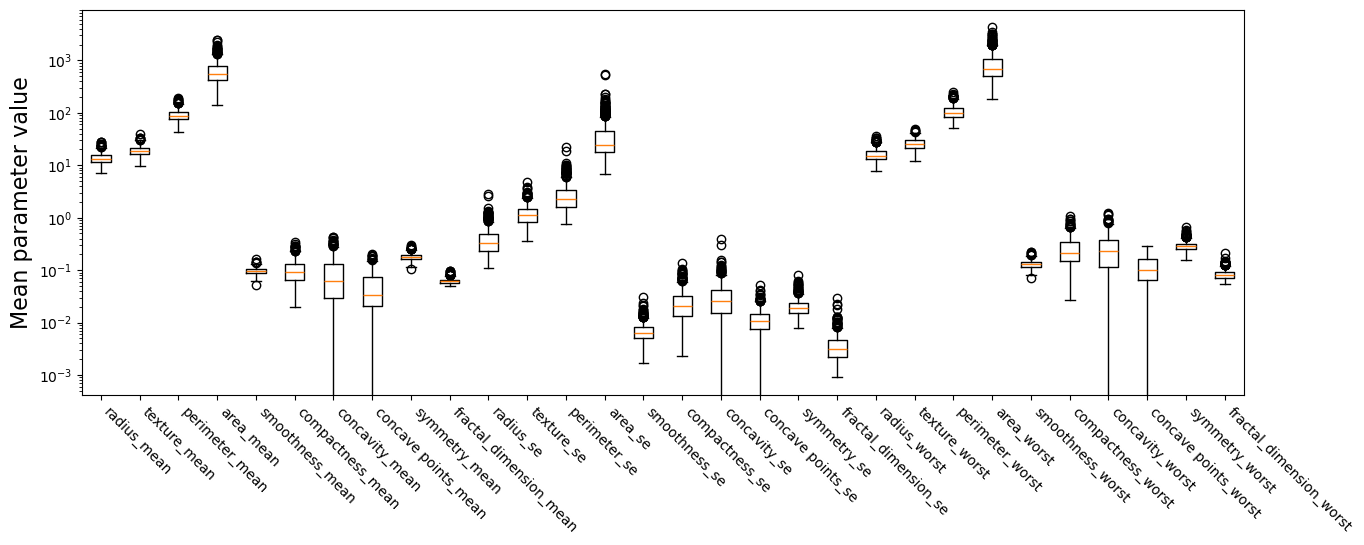

In [7]:
# make a boxplot

fig, ax = subplots(figsize = [15,5])

ax.boxplot(df.loc[:,df.columns != "diagnosis"]) # Remove the boolean feature called "diagnosis"


ax.set_xticklabels(cols[1:],rotation=-45,ha="left") # set the ticklabels and rotate + offset to center to the bin
ax.set_yscale("log")                            # make the y axis into a log scale for visual clarity
ax.set_ylabel("Mean parameter value",fontsize=16)

show()

### Plot the Correlation Matrix (Bivariate):

The array has dimensions of:  (569, 31)


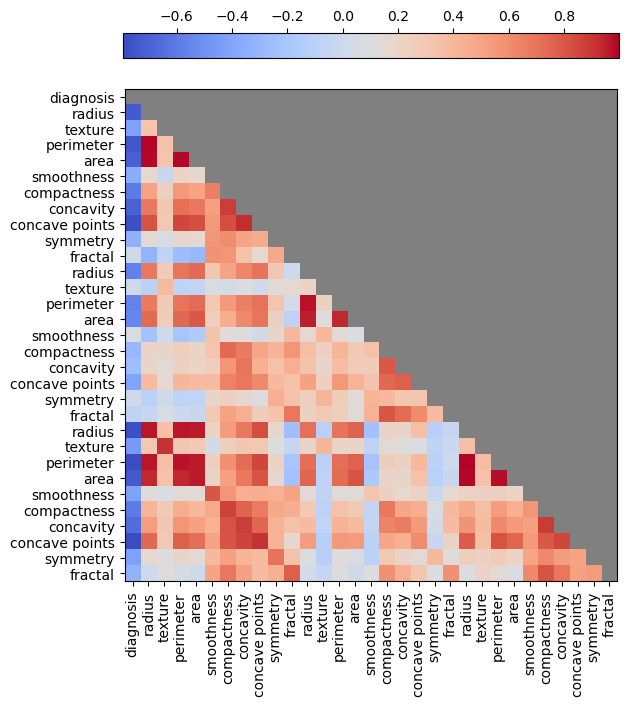

In [8]:
# find correlations within dataset
d = df.to_numpy()                               # convert to numpy array
print("The array has dimensions of: ",d.shape)  # check that the shape is as expected

corr_matrix_full = corrcoef(d,rowvar=False)     # construct the correlation matrix of the dataset
corr_matrix = corr_matrix_full.copy()           # make a copy with the intent to only show half of it.
fill_diagonal(corr_matrix,0)                    # fill the diagonals with 0s so that the autocorrelation does not dominate

mask = triu(ones_like(corr_matrix,dtype=bool),k=1)  # create a mask to "shade" the upper diagonal triangle
corr_matrix[mask] = 0                           # set the upper diagonal to zero to reduce visual clutter

# plotting

fig, ax = subplots(figsize=(8,8))

masked_corr_matrix = ma.masked_where(corr_matrix==0,corr_matrix_full)   # remove offdiagonal cells
cmap = cm.coolwarm.copy()                                               # set the colour scheme
cmap.set_bad(color="gray")                                              # set the colour of "invalid" elements.

im = ax.imshow(masked_corr_matrix,cmap=cmap)
fig.colorbar(im, orientation="horizontal",shrink=0.8,location="top")


ax.set_xticks(arange(31))                     
ax.set_yticks(arange(31))

# Generating new, simpler headers
trimmed_columns=[x.split(sep="_")[0] for x in cols] # this splits the labels and retains the first part

ax.set_xticklabels(trimmed_columns,rotation = 90)    # Set the labels of the ticks
ax.set_yticklabels(trimmed_columns)

show()

# Dimensionality Reduction:

Checkpoints and Guidance:

- Use PCA on all components
- Plot explained variance as a function of component
- Calculate the number of components required to keep a specified amount of the variance
- Create a labels array
- Make a scatter plot of the main components


---
We have the option to do one of two things here:
- Standardise the data PRIOR to PCA 
    - "which linear combination of features leads to the largest numeric variance?"
    - likely "tumour size" so features with area/size/volume etc...
- Do NOT standardize the data prior to PCA
    - "which features explain structure?"
    - allows for heterogeneous features (tumour size to compete against texture or shape variation)


Typically, I would aim to standardize the data prior to PCA using 
`StandardScaler().fit_transform(df)`

but this will complicate the PCA landscape. Here I will take the approach that leverages the simplest interpretation of the data.



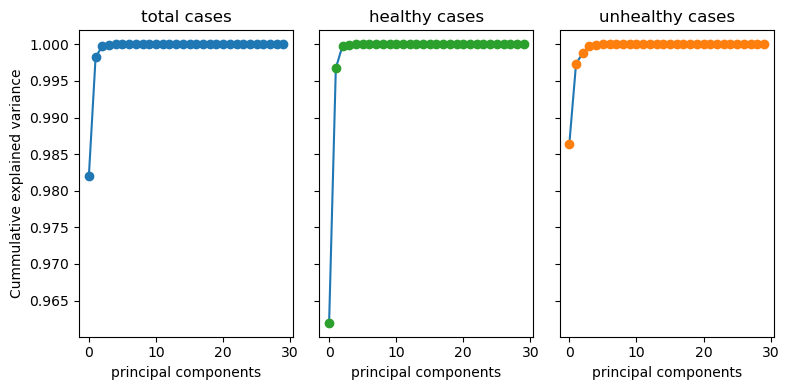

In [9]:
from sklearn.decomposition import PCA


#####################################################################
## PLEASE NOTE: 
# 1. I will NOT standardise the data for analytical simplicity
# 2. the separation here is just for exploratory purposes
#####################################################################

df_total = df.drop(columns="diagnosis")           # we drop the diagnosis column as we do not want any leakage into the fitting
nComp = len(df_total.columns)                     # as many features as columns in the database

# separate data based on diagnosis
healthy     = df[df["diagnosis"]==0].drop(columns="diagnosis")    # healthy cases
unhealthy   = df[df["diagnosis"]==1].drop(columns="diagnosis")    # unhealhty cases



###################################################################################
# initialise PCA
###################################################################################


# full dataframe
whitening = False
pca = PCA(n_components=nComp,whiten=whitening)      # we do not want to rescale the PCs as we want to ensure that we preserve variance structure
pca = pca.fit(df_total)                                   # we introduce the entire dataframe, which contains both 0,1 in the diagnosis feature.
# pca = pca.fit(StandardScaler().fit_transform(df)
# dataframe with healthy cases
pcaH = PCA(n_components=nComp ,whiten=whitening)    # we do not want to rescale the PCs as we want to ensure that we preserve variance structure
pcaH = pcaH.fit(healthy)                            # we input the dataframe with healthy cases only

# dataframe with unhealthy cases
pcaU = PCA(n_components=nComp,whiten=whitening)     # we do not want to rescale the PCs as we want to ensure that we preserve variance structure
pcaU = pcaU.fit(unhealthy)                          # we input the dataframe with unhealthy cases only

# checking how many dimensions are needed in this new dataset
cumExpVar = cumsum(pca.explained_variance_ratio_)
cumExpVarH = cumsum(pcaH.explained_variance_ratio_)
cumExpVarU = cumsum(pcaU.explained_variance_ratio_)


###################################################################################
# plotting
###################################################################################

fig, axes = subplots(1,3,figsize= [8,4],sharey=True)

variances = [cumExpVar,cumExpVarH,cumExpVarU]
var_titles = ["total","healthy","unhealthy"]
colorOptions = [0,2,1]

for ax,cumvar,title,col in zip(axes.ravel(),variances,var_titles,colorOptions):
    ax.plot(range(nComp),cumvar,zorder = 1)
    ax.scatter(range(nComp),cumvar,color=cm.tab10.colors[col],zorder = 2)
    ax.set_xlabel("principal components",fontsize = 10)
    ax.set_title(f"{title} cases",fontsize = 12)

axes[0].set_ylabel("Cummulative explained variance",fontsize = 10)

fig.tight_layout()
show()

In [10]:
pca.explained_variance_ratio_[:5]


array([9.82044672e-01, 1.61764899e-02, 1.55751075e-03, 1.20931964e-04,
       8.82724536e-05])

##### **my remarks**
It is very clear that a SINGLE **principal component** alone represents 98% of all the explainable variance in the system. Two of them account for over 99.7% of the entire variance.
Naively, this tells us that either
- ...the system contains highly correlated features
- or, it contains multiple, highly redundant features + one dominant feature.

I will select 3 PCs as 2 are already overkill.

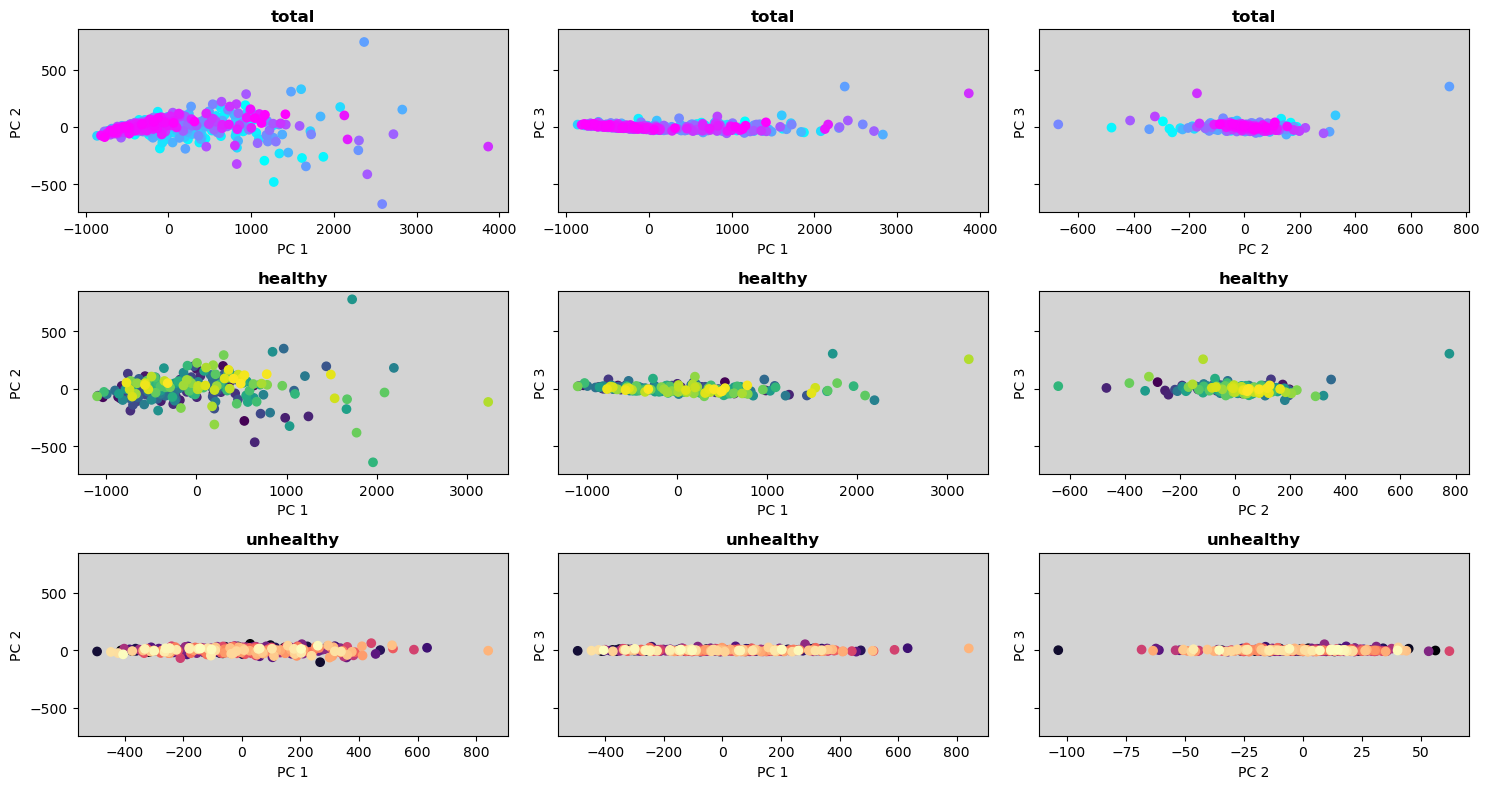

In [11]:
num_of_PCs = 3                                                              # select the number of PC I want to work with
newData  = pca.transform(df_total)[:,:num_of_PCs]                           # transform the total cases dataset
newDataH = pcaH.transform(healthy)[:,:num_of_PCs]                           # transform the healthy cases dataset into the new basis and select the first 3 PCs.
newDataU = pcaU.transform(unhealthy)[:,:num_of_PCs]                         # transform the unhealthy cases dataset into the new basis
combinations = list(itertools.combinations([i for i in range(num_of_PCs)],2))     # find the combinatorics with 3 features



# display the results

fig, axes = subplots(3,3,sharex=False,sharey=True,figsize = [15,8])
datasets = [newData,newDataH,newDataU]
titles = ["total","healthy","unhealthy"]
themeChoices = ["cool","viridis","magma"]

for row, (data,title) in enumerate(zip(datasets,titles)):
    for ax, (i,j) in zip(axes[row],combinations):
        ax.scatter(data[:,i],data[:,j] ,c=range(len(data)),cmap= themeChoices[row])
        ax.set_xlabel(f"PC {i+1}")
        ax.set_ylabel(f"PC {j+1}")
        ax.set_title(title,fontweight = "bold")
        ax.set_facecolor("lightgray")

# xranges = [[-2.5,6],[-2.5,6],[-7.5,7.5]]
# for i in range(3):
#     for ax in axes[:,i]:
#         ax.set_xlim(xranges[i])


fig.tight_layout()

show()

**Sanity check:** PC1 dominates the variance leading to highly anisotropic ellipses. Exactly what we saw from the cum.variance from earlier (PC1 accounted for ~98% of total variance).

We can see that the distinction between healthy and unhealthy does lead to slightly different principal components. 

This is a good start, as although they bare many similarities, they maybe be possible to have them separated using some ML technique.

---

### Extracting potentially powerful features rather than principal components.

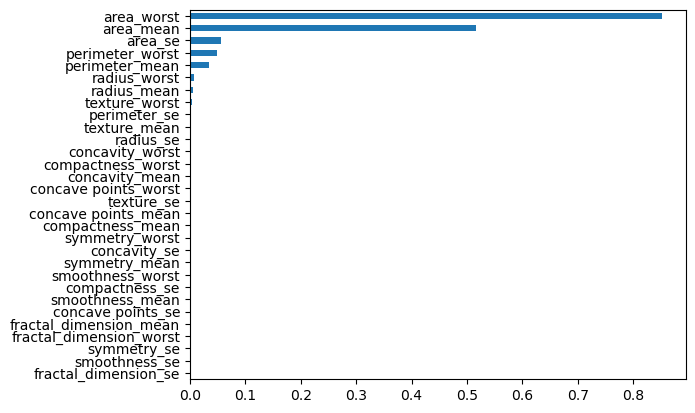

In [12]:
from pandas import Series

pc1_loadings = pca.components_[0]   # the loadings of the FIRST principal component
pc2_loadings = pca.components_[1]   # the loadings of the second principal component

# create a "map" between the loadings and the labels, sort them by absolute value, and have them in descending order so that the top bar is the highest in loading.
pc1_l = Series(pc1_loadings,index=df_total.columns,name = "PC1 loading").sort_values(ascending=False, key= abs)   # loadings for PC1
pc2_l = Series(pc2_loadings,index=df_total.columns,name = "PC2 loading").sort_values(ascending=False, key= abs)   # loadings for PC2

# quick plotting just for sanity check
pc1_l.abs().sort_values(ascending=True).plot(kind="barh");   # make a bar plot

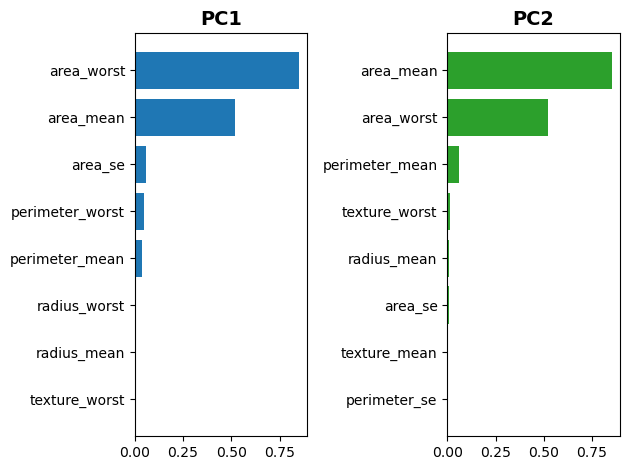

In [13]:
# slightly more format plotting of the most prominent features

fig, ax = subplots(1,2)
num_of_features = 8

# NOTE: I take the abs as some loading may be negative. We currently only look for scale.
ax[0].barh(arange(num_of_features),pc1_l.abs().values[:num_of_features][::-1])
ax[0].set_yticks(arange(num_of_features))
ax[0].set_yticklabels(list(pc1_l.keys())[:num_of_features][::-1])
ax[0].set_title("PC1",fontsize = 14,fontweight= "bold")

# NOTE: I take the abs as some loading may be negative. We currently only look for scale.
ax[1].barh(arange(num_of_features),pc2_l.abs().values[:num_of_features][::-1],color=cm.tab10.colors[2])
ax[1].set_yticks(arange(num_of_features))
ax[1].set_yticklabels(list(pc2_l.keys())[:num_of_features][::-1])
ax[1].set_title("PC2",fontsize = 14,fontweight= "bold")

fig.tight_layout()
show()

---

What is quite neat here, is that the primary culprits for breast cancer are features with dimensions of "size", "area", "radius", which makes perfect sense in the context of what we are working with. This is pretty much spot on in terms of what I would have hoped to see. 

Both PC1 and PC2 have very similar features selected. And we can see that past the 5th feature, the loadings become quite negligible. The top 2 features matter the most, and would most likely not seek anything further than feature #5 or so.


---

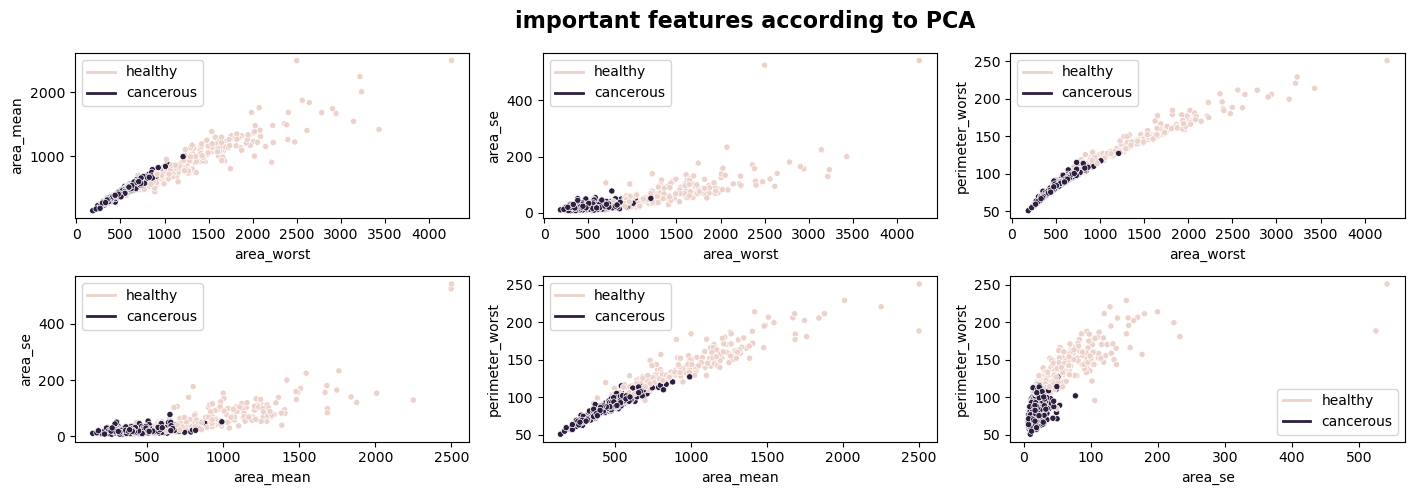

In [14]:
num_of_features = 4                                                             # select the number of features I want to work with. For the sake of combinatorics, i went with 4
prime_features = list(pc1_l[:num_of_features].keys())                           # extract the top X features that lead to highest explainable variance within the system from PC1
fcombos = list(itertools.combinations([i for i in range(num_of_features)],2))   # calculate the combinatorics for all X features so we can make 2D plots for each feature pair
cmap = cubehelix_palette(as_cmap=True)                                          # define your favourite colour scheme


#####################################################################
# plotting

fig, axes = subplots(2,3,figsize = [15,5])
fig.suptitle("important features according to PCA",fontsize = 16,fontweight = "bold")
custom_line = [Line2D([0],[0],color=cmap(0.),label="healthy",lw=2),Line2D([0],[0],color=cmap(1.),label="unhealthy",lw=2)]

for index,(ax, combo) in enumerate(zip(axes.ravel(),fcombos)):
    ax.scatter(df_total[prime_features[combo[0]]],df_total[prime_features[combo[1]]],
               c = df["diagnosis"],
               vmin=0,s=20,edgecolor = "white",linewidth=0.5,cmap=cmap)
    ax.set_xlabel(prime_features[combo[0]])
    ax.set_ylabel(prime_features[combo[1]])
    # ax.set_facecolor("gray")
    ax.legend(custom_line,["healthy","cancerous"])

fig.tight_layout(rect=[0, 0, 0.95, 1])

show()

## closing remarks

Using PCA, we were able to identify important features within the dataset, and we can clearly see that if we were to key them based on the diagnosis, then the separation is quite nice. There is little overlap between the two keys.

---

# Clustering:

- Use the GMM or KMEANS algorithm
- Test different numbers of components
- Assess using adjusted rand score
- Plot data in scatterplot using the predicted labels

In [15]:
RANDOM_SEED = 20260109
seed(RANDOM_SEED)

# I will start with the simplest of cases that we have from the above PCA section.
## this corresponds to the bottom right plot of `area_se` vs `periment_worst`


########################################################
# training
########################################################

x_train = StandardScaler().fit_transform(df[["area_se","perimeter_worst"]])
clf = GaussianMixture(n_components=2)                   # initialise the GMM with 2 components
clf.fit(x_train)                                        # train the GMM
y = clf.predict(x_train)                                # predict labels based on clustering

km = KMeans(n_clusters=2, random_state=RANDOM_SEED)     # initialise a K-means clustering model
y_km = km.fit_predict(x_train)                          # train the K-means model

y_true = df["diagnosis"].to_numpy()                     # determine the true labels between healthy/unhealthy

########################################################
# generating the parameter space
########################################################

resolution = 100                                                        # density of the statespace
a, b = 0.8,1.2                                                          # coefficients for the statespace range based on the data min/max values
vec_a = linspace(a*min(x_train[:,0]),b*max(x_train[:,0]), resolution)
vec_b = linspace(a*min(x_train[:,1]),b*max(x_train[:,1]), resolution)
grid_a,grid_b = meshgrid(vec_a, vec_b)
XY_statespace = c_[grid_a.ravel(),grid_b.ravel()]

Z_score = clf.score_samples(XY_statespace)
z_s     = Z_score.reshape(grid_a.shape)

c:\Users\hadif\.conda\envs\L2D_2025\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\hadif\.conda\envs\L2D_2025\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


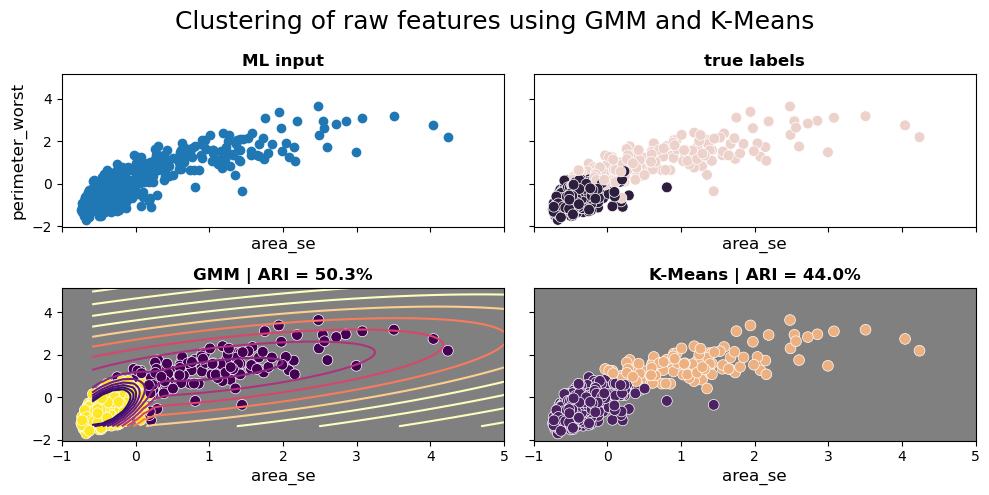

In [16]:
########################################################
# plotting
########################################################

fig, ax = subplots(2,2,sharex=True,sharey=True,figsize = [10,5])

ax[0,0].scatter(x_train[:,0],x_train[:,1])
ax[0,0].set_xlim([-1,5])
ax[0,0].set_ylabel("perimeter_worst",fontsize = 12)
ax[0,0].set_xlabel("area_se",fontsize = 12)
ax[0,0].set_title("ML input",fontweight = "bold",fontsize = 12)


ax[0,1].scatter(x_train[:,0],x_train[:,1],c =df["diagnosis"],
              vmin=0,s=60,edgecolor = "white",linewidth=0.5,
              cmap=cmap)
ax[0,1].set_xlabel("area_se",fontsize = 12)
ax[0,1].set_title("true labels",fontweight = "bold",fontsize = 12)


scoringGMM=adjusted_rand_score(y_true,y)
ax[1,0].scatter(x_train[:,0],x_train[:,1],c = y,
                s=60,edgecolor = "white",linewidth=0.5)
ax[1,0].contour(grid_a,grid_b,-z_s,
              norm = Normalize(vmin=-1,vmax =1e1),
              levels = logspace(0,2,20), cmap = "magma")
ax[1,0].set_facecolor("gray")
ax[1,0].set_xlabel("area_se",fontsize = 12)
ax[1,0].set_title(f"GMM | ARI = {round(scoringGMM,3)*100}%",fontweight = "bold",fontsize = 12)


scoringKM=adjusted_rand_score(y_true,y_km)
ax[1,1].scatter(x_train[:,0],x_train[:,1],c = y_km,
                s = 60,edgecolor = "white",
                linewidth = 0.5,
                cmap = color_palette("flare",as_cmap=True))
ax[1,1].set_facecolor("gray")
ax[1,1].set_xlabel("area_se",fontsize = 12)
ax[1,1].set_title(f"K-Means | ARI = {round(scoringKM,3)*100}%",
                  fontweight = "bold",fontsize = 12)





fig.suptitle("Clustering of raw features using GMM and K-Means",fontsize = 18)

fig.tight_layout()
show()


Not a bad result to have an ARI ~50%.

---

### What if we use principal components instead?

c:\Users\hadif\.conda\envs\L2D_2025\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\hadif\.conda\envs\L2D_2025\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\hadif\.conda\envs\L2D_2025\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


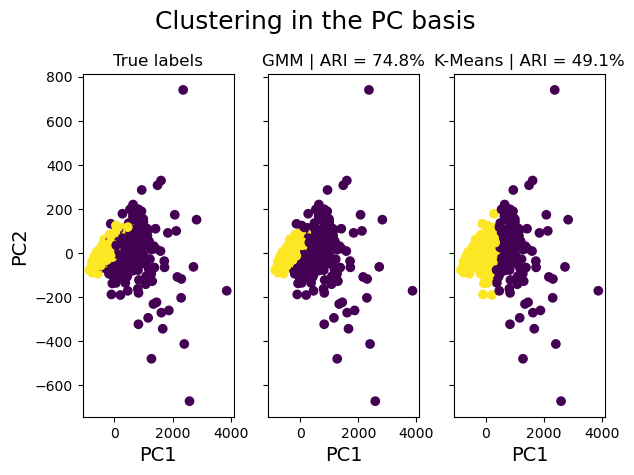

In [17]:
x_trainPCA = vstack([newData[:,0],newData[:,1]]).T              # use the transformed data from the standardised, non-whitened, PCA

# Gaussian-mixture model
###############################################################
clf = GaussianMixture(n_components=2,random_state=RANDOM_SEED);  # initialise
clf.fit(x_trainPCA);                                             # train
y_pca = clf.predict(x_trainPCA) ;                                # predict
y_pca_GMM_score = adjusted_rand_score(y_true,y_pca);             # calculate ARI


# K-means model
###############################################################
km_pca = KMeans(n_clusters=2,random_state=RANDOM_SEED);
km_pca.fit(x_trainPCA);
y_km_pca = km_pca.fit_predict(x_trainPCA);
y_pca_KM_score = adjusted_rand_score(y_true,y_km_pca);


# plotting
###############################################################
fig, ax = subplots(1,3,sharey=True)

ax[0].scatter(x_trainPCA[:,0],x_trainPCA[:,1],c = y_true)
ax[0].set_title("True labels")
ax[0].set_ylabel("PC2",fontsize = 14)
ax[0].set_xlabel("PC1",fontsize = 14)

ax[1].scatter(x_trainPCA[:,0],x_trainPCA[:,1],c = y_pca)
ax[1].set_xlabel("PC1",fontsize = 14)
ax[1].set_title(f"GMM | ARI = {round(y_pca_GMM_score,3)*100}%")

ax[2].scatter(x_trainPCA[:,0],x_trainPCA[:,1],c = y_km_pca)
ax[2].set_xlabel("PC1",fontsize = 14)
ax[2].set_title(f"K-Means | ARI = {round(y_pca_KM_score,3)*100}%")

fig.suptitle("Clustering in the PC basis", fontsize = 18)
fig.tight_layout()
show()


Thankfully, we find that there is a substantial improvement in working in the PC basis. This of course encapsulates much more than two features. It is also very important that we do not whiten the data.

---

# 🏷️ Classification:

- Train a number of classifiers from the scikit-learn library
- Obtain the `.score` and compare the outcome for the classifiers
- Train a number of classifiers and plot the ROC `roc_curve`, with the score obtained from `roc_auc_score`
- Repeat the above workflow with reduced data after PCA, and compare the results
- Pick the classifier that scores highest, fit this to the data (original and reduced) and plot the feature importances



In [18]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, roc_auc_score

RANDOM_STATE = 20260109
classifiers = {
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
    'AdaBoost (Random Forest)': AdaBoostClassifier(RandomForestClassifier(random_state=RANDOM_STATE),random_state=RANDOM_STATE),
    'Gradient Boost (Random Forest)': GradientBoostingClassifier(random_state=RANDOM_STATE),
    'k-nearest neighbour': KNeighborsClassifier(),
    'SVC (RBF)': SVC(random_state=RANDOM_STATE),
    'SVC (Linear)': LinearSVC(random_state=RANDOM_STATE),
    'Multi-layer Perceptron': MLPClassifier(max_iter=5000, random_state=RANDOM_STATE)
}

splitting the data, and training it on each classifier.
We then plot the scores of each classifier in a bar plot

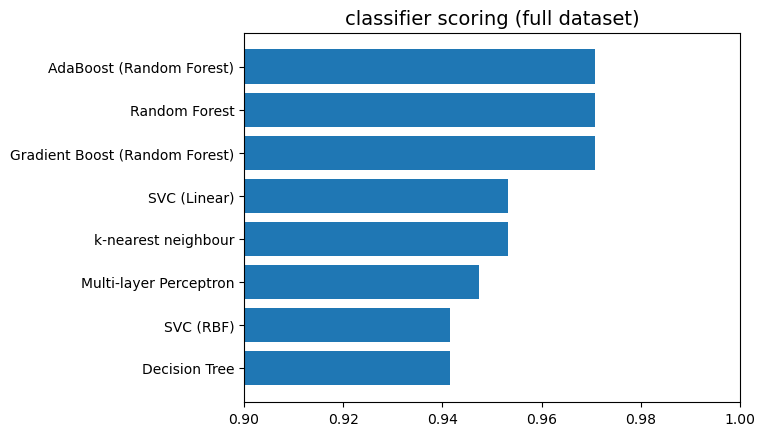

In [19]:
X = df_total.to_numpy()   # i am using the prime features as identified by PCA to speed up the process
y = df["diagnosis"].to_numpy()

# an SSS is a bit overkill here
# a simple train/test/split should be enough
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=RANDOM_STATE, shuffle=True)

score_clf = []  # for storing clf scores


for name, clf in classifiers.items():
    clf.fit(X_train,y_train)                    # train the classifier
    y_pred = clf.predict(X_test)                # predict using the classifier
    score_clf.append(clf.score(X_test,y_test))  # score the clf and append to the list

bins = arange(len(score_clf))
class_order = Series(score_clf,index = classifiers.keys()).sort_values()    # create a series to allow for sorting


################################### plotting
fig, ax = subplots()

ax.barh(bins, class_order.values)
ax.set_yticks(arange(0,8))
ax.set_yticklabels(class_order.keys())
ax.set_xlim([0.9,1])
ax.set_title("classifier scoring (full dataset)",fontsize = 14)
show()

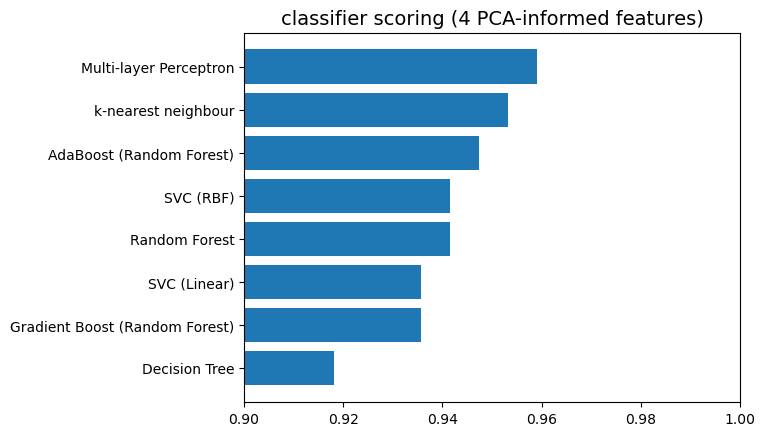

In [20]:
X = df[prime_features].to_numpy()   # i am using the prime features as identified by PCA to speed up the process
y = df["diagnosis"].to_numpy()

# an SSS is a bit overkill here
# a simple train/test/split should be enough
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X, y, test_size=.3, random_state=RANDOM_STATE, shuffle=True)

score_clf_p = []  # for storing clf scores


for name, clf in classifiers.items():
    clf.fit(X_train_p,y_train_p)                    # train the classifier
    y_pred = clf.predict(X_test_p)                # predict using the classifier
    score_clf_p.append(clf.score(X_test_p,y_test_p))  # score the clf and append to the list

bins = arange(len(score_clf_p))
class_order_p = Series(score_clf_p,index = classifiers.keys()).sort_values()    # create a series to allow for sorting


################################### plotting
fig, ax = subplots()

ax.barh(bins, class_order_p.values)
ax.set_yticks(arange(0,8))
ax.set_yticklabels(class_order_p.keys())
ax.set_xlim([0.9,1])
ax.set_title("classifier scoring (4 PCA-informed features)",fontsize = 14)
show()

ROC and AUC evaluation.

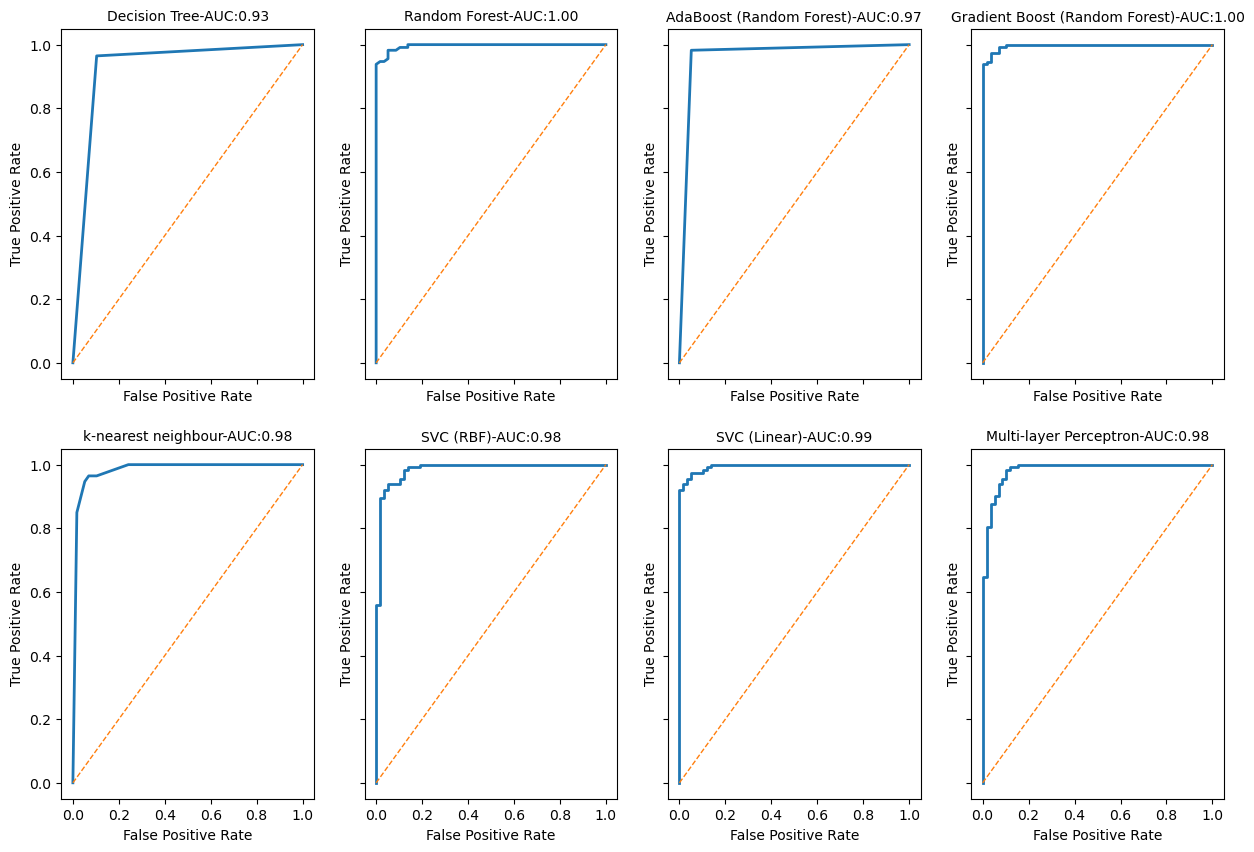

In [21]:
fig, all_axes = subplots(figsize = [15,10], ncols = 4,nrows=2, sharey=True, sharex=True)

for ax, (name, clf) in zip(all_axes.ravel(), classifiers.items()):
    #train the model
    clf.fit(X_train,y_train)

    # check if the object has a `decision_function`
    if hasattr(clf,"decision_function"):
        y_score = clf.decision_function(X_test)
    
    else:
        y_score = clf.predict_proba(X_test)[:,1]
    
    # Obtain the x- and y-axes for values for the ROC curve:

    #false positives and true positives
    fpr, tpr, thresh = roc_curve(y_test,y_score)
    
    # roc and auc score
    roc_auc = roc_auc_score(y_test,y_score)



    # plotting
    ax.plot(fpr,tpr, lw=2)
    ax.plot([0,1],[0,1],lw=1,linestyle = "--")

    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")

    label = "{}-AUC:{:.2f}".format(name, roc_auc)
    ax.set_title(label, fontsize = 10)

show()

### Now using PCA data

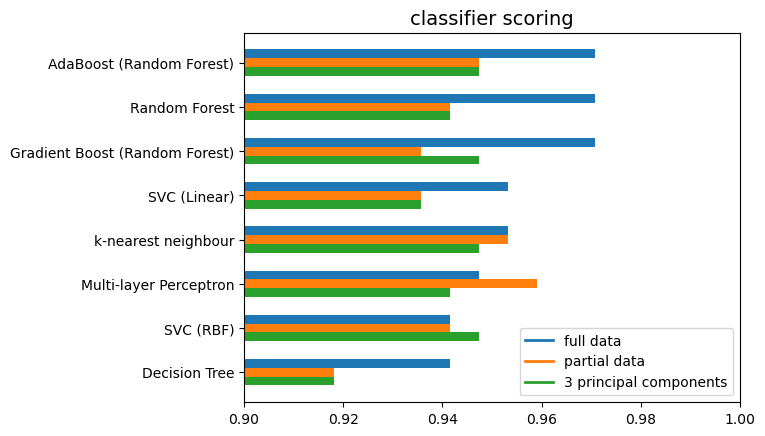

In [22]:
X = newData
y = df["diagnosis"].to_numpy()

# an SSS is a bit overkill here
# a simple train/test/split should be enough
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X, y, test_size=.3, random_state=RANDOM_STATE, shuffle=True)

score_clf_pca = []  # for storing clf scores


for name, clf in classifiers.items():
    clf.fit(X_train_pca,y_train_pca)                    # train the classifier
    y_pred = clf.predict(X_test_pca)                # predict using the classifier
    score_clf_pca.append(clf.score(X_test_pca,y_test_pca))  # score the clf and append to the list

bins = arange(len(score_clf_pca))
class_order_pca = Series(score_clf_pca,index = classifiers.keys())    # create a series to allow for sorting


################################### plotting
fig, ax = subplots()
bar_height = 0.2

ax.barh(bins+bar_height, class_order.values,height=bar_height)
ax.barh(bins, class_order_p[class_order.keys()].values,height=bar_height)
ax.barh(bins-bar_height, class_order_pca[class_order.keys()].values,height=bar_height)

ax.set_yticks(arange(0,8))
ax.set_yticklabels(class_order.keys())
ax.set_xlim([0.9,1])
ax.set_title("classifier scoring",fontsize = 14)

custom_line = [
    Line2D([0],[0],color=cm.tab10.colors[0],label="healthy",lw=2),
    Line2D([0],[0],color=cm.tab10.colors[1],label="unhealthy",lw=2),
    Line2D([0],[0],color=cm.tab10.colors[2],label="unhealthy",lw=2)]

ax.legend(custom_line,["full data","partial data","3 principal components"])
show()


we can see that although we are using a significantly reduced dataset (just 3 PCs) we are effectively getting the same scoring as by training against the entire dataset.

---

### Importances

adaboost random forest was the highest scoring classifier, which thankfully is fully interpretable and does produce importances

AdaBoostClassifier(estimator=RandomForestClassifier(random_state=20260109),
                   random_state=20260109)


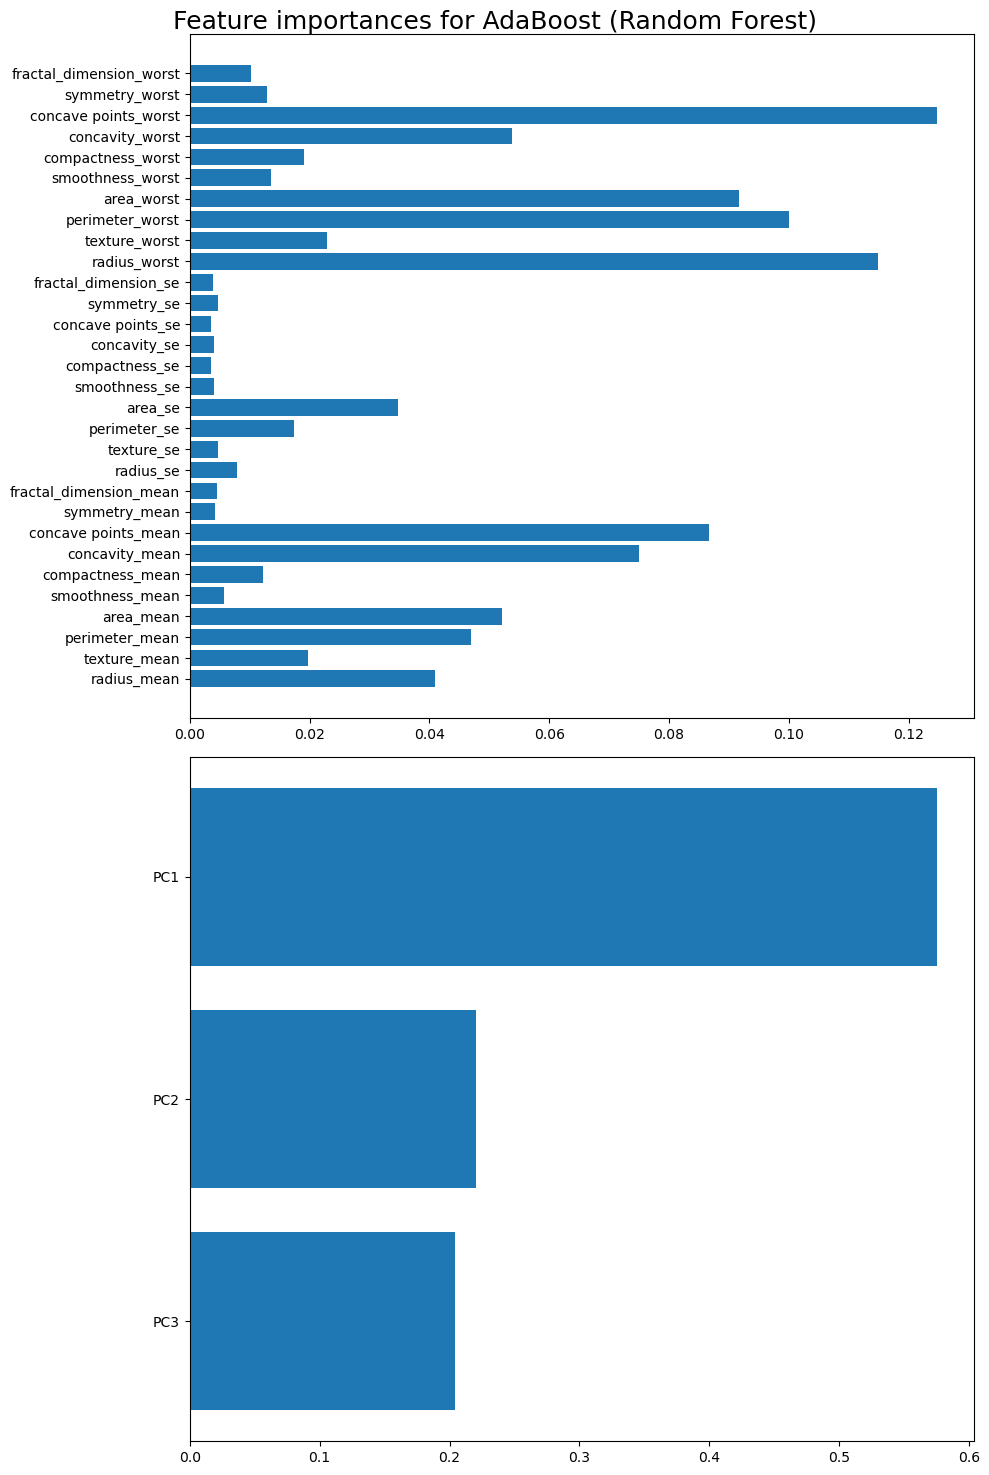

In [ ]:
clf_index = 2   # adaboost random forest
clf = classifiers[list(classifiers.keys())[clf_index]]
print(clf)
importances = clf.fit(X_train,y_train).feature_importances_

clf = classifiers[list(classifiers.keys())[clf_index]]
importances_pca = clf.fit(X_train_pca,y_train_pca).feature_importances_

fig,ax = subplots(2,1,figsize = [10,15])

bins = arange(importances.shape[0])
ax[0].barh(bins,importances)
ax[0].set_yticks(arange(importances.shape[0]))
ax[0].set_yticklabels(df_total.keys())


bins_pca = arange(importances_pca.shape[0])
ax[1].barh(bins_pca,importances_pca[::-1])
ax[1].set_yticks(arange(importances_pca.shape[0]))
ax[1].set_yticklabels(["PC1","PC2","PC3"][::-1])

fig.suptitle("Feature importances for "+
              list(classifiers.keys())[clf_index],fontsize = 18)
fig.tight_layout()
show()


---

# The end